<center><h1>Py-Galaxies examples</h1></center>

# SUB-HALO Stars

## Import modules

In [1]:
import os, sys
sys.path.insert(0,os.path.join(os.getcwd(),'PyGalaxies')) # This is needed to import C routines.
from PyGalaxies import Parameters, Monitor, HDF_graph_properties, Halos
import time
import numpy as np



model_param_filepath='Input_Params/input_params.yml'
debug_flag = False
verbosity = 1 
time_code = True

## Get model params and print

In [2]:
model_params = Parameters.ModelParams(model_param_filepath,verbosity,debug_flag)
#model_params.precalculate_common_constants()
model_params.load_paramters_to_C()
model_params.read_in_data_tables_from_c()
model_params.output_params() 

input_files         : {'graph_file': '../Input Data/mega_graph_mini_09-11.hdf5'}
output_files        : {'halo_file': '../Output Data/SMT13Output_class_based.hdf5'}
cosmology           : {'omega_m': {'Description': 'Matter density parameter', 'Value': 0.3, 'Units': 'None'}, 'omega_lambda': {'Description': 'Cosmo const parameter', 'Value': 0.7, 'Units': 'None'}, 'omega_gamma': {'Description': 'Radiation density parameter', 'Value': 0.0, 'Units': 'None'}, 'H0': {'Description': 'The hubble parameter evaluated at t=0 (from plank)', 'Value': 67.66, 'Units': '(km/s)/Mpc'}, 'zr_reionization': {'Description': 'The redshift at which reionization occured', 'Value': 15, 'Units': 'None'}, 'z0_reionization': {'Description': 'The redshift at which reionization occured?', 'Value': 6, 'Units': 'None'}, 'f_baryon': {'Description': 'Baryon fraction', 'Value': 0.155, 'Units': 'None'}, 'mu': {'Description': 'Mean amount of particles. Can also be linked to metallicity and not const', 'Value': 0.59265, 'unit

## Run main routine

In [3]:
# Open the input HDF5 file containing graph groups and create an output file.
HDF_properties = HDF_graph_properties.HDFProperties(model_params)

start_time = time.time()


graph_arrays = []
graph_lengths = [] 
n_halo_in_graph = []


for graph_ID in range(0,HDF_properties.no_of_graphs)[:]:

    if verbosity >= 2: print('Processing graph',graph_ID)
    

    graph_properties = HDF_graph_properties.GraphProperties(graph_ID,
                                       HDF_properties.graph_input_file,
                                       model_params,
                                       HDF_properties.part_mass)

    
    array_of_halo_properties = np.empty(len(graph_properties.graph_halo_ids),
                                        dtype = object)
    
    if type(graph_properties.n_subhalos) == int:
        graph_lengths.append(np.nan)
        continue
    else:
        n_halo_in_graph.append(graph_properties.n_halos_in_graph)
        graph_lengths.append(np.sum(graph_properties.n_subhalos))
    
    for snap_ID in graph_properties.generation_id:
        

        if graph_properties.generation_start_index[snap_ID] == 2**30:
            continue
    
        
        this_generation_halo = graph_properties.graph_halo_ids[
                               graph_properties.generation_start_index[snap_ID]:
                               graph_properties.generation_start_index[snap_ID] + 
                               graph_properties.generation_length[snap_ID]]
        
        for halo_ID in this_generation_halo:
            
            halo = Halos.HaloProperties(str(graph_ID), snap_ID, halo_ID,
                                  graph_properties, HDF_properties.part_mass,
                                  HDF_properties.dtype_subhalo_stores)
            

            halo.halo_descendent_props()

            halo.calc_halo_DM_descend(HDF_properties.part_mass)

            halo.calc_halo_attrs_descend(HDF_properties.part_mass, array_of_halo_properties,
                                         HDF_properties.halo_descend_attrs)


            
            halo.calc_subhalo_attrs_descend(graph_properties, HDF_properties, array_of_halo_properties)
            
            halo.add_halo_baryon_mass_then_topup(HDF_properties)
            
            halo.set_baryon_fraction(array_of_halo_properties, model_params.f_baryon)
            
            halo.calculate_hot_gas_temp(model_params.H0, model_params.mu, model_params.m_p, model_params.k_B)
            
            halo.calculate_metal_dependent_cooling_rate()
            
            halo.add_stellar_mass() # Adds on Berhoozi 
            
            
            halo.done = True
            
            array_of_halo_properties[halo_ID] = halo

            HDF_properties.n_halo +=1 

    # Save output
    HDF_properties.output_halos(array_of_halo_properties)

    graph_arrays.append(array_of_halo_properties)


# Close input file
HDF_properties.close_graph_io(HDF_properties.graph_input_file)


# Close output files
if HDF_properties.halo_output_iRec > 0: 

    halo_output_iRec = HDF_properties.flush_output()
    
HDF_properties.close_graph_io(HDF_properties.halo_output_file)


end_time = time.time()
print('This took {} seconds'.format(end_time-start_time))

This took 59.20884609222412 seconds


In [4]:
vars(array_of_halo_properties[8])

{'graph_ID': '975',
 'snap_ID': 47,
 'halo_ID': 8,
 'catalog_ID': 8195,
 'mass': 34582753538.74673,
 'nprog': 1,
 'prog_start': 7,
 'prog_end': 8,
 'prog_ids': array([7]),
 'prog_mass': array([3.45827535e+10]),
 'ndesc': 1,
 'desc_start': 8,
 'desc_end': 9,
 'desc_ids': array([9]),
 'desc_mass': array([3.32526476e+10]),
 'mean_pos': array([35.19711069, 50.59284738, 36.0707151 ]),
 'velocity_dispersion_3D': 42.63950761595804,
 'mean_vel': array([-383.57999009,   64.7667558 ,  173.79184312]),
 'rms_radius': 0.04378700778028628,
 'redshift': 0.4565772503469474,
 'total_halo_stellar_mass': 0.0,
 'total_halo_baryon_mass': array([5.49321969e+09]),
 'hot_gas_mass': array([5.49321969e+09]),
 'hot_gas_temp': 1279.9817686888978,
 'gas_metalicity': 0.0001,
 'cold_gas': array([0.]),
 'ejected_gas': array([0.]),
 'metal_dependent_cooling_rate': 8.547533129118532e-24,
 'intracluster_stellar_mass': array([0.]),
 'mass_from_progenitors': 4.599872470468075e+19,
 'mass_baryon_from_progenitors': 0.0,
 'i

In [5]:
import matplotlib.pyplot as plt

C:\Users\Andrew\Anaconda3new\envs\FYP\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


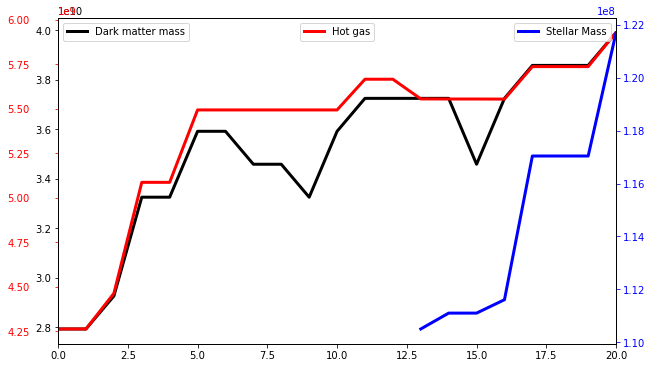

In [6]:
hot_gass = []
dm_mass = []
stellar_mass = [] 
prog_mass = []
for i in range(0,23):
    hot_gass.append(array_of_halo_properties[i].hot_gas_mass)
    dm_mass.append(array_of_halo_properties[i].mass)
    prog_mass.append(array_of_halo_properties[i].mass_from_progenitors)
    stellar_mass.append(array_of_halo_properties[i].sub_halo_attrs['stellar_mass'])
    

fig, ax1 = plt.subplots(figsize = (10, 6))
    
ax1.plot(dm_mass,color = 'black', lw = 3,label='Dark matter mass')
ax2 = ax1.twinx()

    
ax2.plot(hot_gass, color = 'red', lw = 3,label = 'Hot gas')

ax3 = ax2.twinx()
stellar_mass = [i for i in stellar_mass if len(i) == 1]

ax3.plot(np.arange(0,len(stellar_mass),1) + 13,stellar_mass, label ='Stellar Mass',lw =3,color='blue')
plt.xlim(0,20)
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')
ax1.yaxis.label.set_color('red')
ax1.tick_params(axis='y', colors='black')
ax2.tick_params(axis='y', colors='red',pad=25)
ax3.tick_params(axis='y', colors='blue')
offset = ax2.yaxis.get_major_formatter().get_offset()
# ax2.yaxis.offsetText.set_visible(False)

# ax2.set_ylabel(offset)
plt.show()

In [7]:
# Plot hot gas, hotgas + stellar mass. 